In [21]:
from datasets import load_dataset 
import torch
import torch.nn as nn
import PIL
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from adam import FusedAdam

In [22]:
def get_data():
    dataset = load_dataset('mnist', split='train')
    return dataset['image'], dataset['label']

raw_images, raw_labels = get_data()

Reusing dataset mnist (/home/paperspace/.cache/huggingface/datasets/mnist/mnist/1.0.0/fda16c03c4ecfb13f165ba7e29cf38129ce035011519968cdaf74894ce91c9d4)


In [23]:
def transforms(examples):
    # each example is a PIL.PngImagePlugin.PngImageFile
    # resize to 28x28
    # convert to tensor
    to_tensor = ToTensor()
    # compose
    transforms = Compose([to_tensor])
    examples = [transforms(example) for example in examples]
    examples = torch.stack(examples)
    return examples

def preprocess_data(images, labels):
    # each image is a PIL.PngImagePlugin.PngImageFile

    # open it and turn it into a 2d tensor
    images = transforms(images)
    
    # one hot encode the labels
    # labels = torch.nn.functional.one_hot(labels, num_classes=10)
    labels = torch.tensor(labels)

    return images, labels

images, labels = preprocess_data(raw_images, raw_labels)
# show me an image to make sure it did it right 
print(images[0])


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [24]:
class CNN(nn.Module):
    def __init__(self, model_size=1, dropout=None):
        super(CNN, self).__init__()
        # batch is a 4d tensor of shape (batch_size, 1, 28, 28)
        self.model_size = model_size
        # predict the digit likelihood 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=model_size, kernel_size=3, stride=1, padding=1)
        # batch is a 4d tensor of shape (batch_size, 16, 28, 28)
        self.conv2 = nn.Conv2d(in_channels=model_size, out_channels=model_size*2, kernel_size=3, stride=1, padding=1)
        # batch is a 4d tensor of shape (batch_size, 32, 28, 28)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # batch is a 4d tensor of shape (batch_size, 32, 14, 14)
        self.fc1 = nn.Linear(in_features=model_size*2*14*14, out_features=10)
        # batch is a 2d tensor of shape (batch_size, 10)
        self.dropout = dropout
        if (dropout is not None):
            self.dropout1 = nn.Dropout(dropout)

        # last steps to get the digit likelihood
        self.softmax = nn.Softmax(dim=1)

    
    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.pool(batch)
        batch = batch.view(-1, self.model_size*2*14*14)
        batch = self.fc1(batch)
        if (self.dropout is not None):
            batch = self.dropout1(batch)
        batch = self.softmax(batch)
        return batch 



In [30]:
import math 
import gc

# if (model):
#     model.cpu() 
#     del model
#     gc.collect()
#     torch.cuda.empty_cache()
#use cuda for everything:

dropout = 0.2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

images = images.to(device)
labels = labels.to(device)

num_epochs = 1
batch_size = 256

dataset_sizes = [  800, 1600, 3200, 6400, 12800, 25600, 51200 ]
model_sizes = [2, 4, 8, 16, 32, 64, 128, 256]

results = []

for dataset_size in dataset_sizes:
    for model_size in model_sizes:

        print("dataset_size=", dataset_size)
        print("model_size=", model_size)
        model = CNN(model_size, dropout).to(device)
        print("num_params=", sum(p.numel() for p in model.parameters() if p.requires_grad))
        criterion = nn.CrossEntropyLoss()

        train_images = images[:dataset_size]
        train_labels = labels[:dataset_size]

        val_images = images[-1000:]
        val_labels = labels[-1000:]

        # learning rate as a proportion of initialization scale, i.e. 1/sqrt(fan_in) for the standard Kaiming He initialization:
        optimizer = FusedAdam(model.parameters(), lr=0.001/math.sqrt(model_size), betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

        for epoch in range(num_epochs):
            for i in range(0, len(train_images), batch_size):
                batch = train_images[i:i+batch_size]
                batch_labels = train_labels[i:i+batch_size]

                optimizer.zero_grad()
                output = model(batch)
                # output is a 2d tensor of shape (batch_size, 10)
                # labels is a 1d tensor of shape (batch_size)
                loss = criterion(output, batch_labels)
                loss.backward()
                optimizer.step()
        
        # get validation loss
        with torch.no_grad():
            output = model(val_images)
            loss = criterion(output, val_labels)
            # get percentage error too:
            percent = torch.sum(torch.argmax(output, dim=1) == val_labels).item() / len(val_labels)
            print("Model size: ", model_size, "Validation loss: ", loss.item(), "Validation percent: ", percent)
        
        computed_used = torch.cuda.max_memory_allocated() / 1024**3
        results.append({ "model_size": model_size, "dataset_size": dataset_size, "loss": loss.item(), "memory_used": computed_used, "percent": percent })

        model.cpu() 
        del model
        gc.collect()
        torch.cuda.empty_cache()


dataset_size= 800
model_size= 2
num_params= 7946
Model size:  2 Validation loss:  2.2965478897094727 Validation percent:  0.335
dataset_size= 800
model_size= 4
num_params= 16026
Model size:  4 Validation loss:  2.2963926792144775 Validation percent:  0.102
dataset_size= 800
model_size= 8
num_params= 32618
Model size:  8 Validation loss:  2.290192127227783 Validation percent:  0.268
dataset_size= 800
model_size= 16
num_params= 67530
Model size:  16 Validation loss:  2.283728837966919 Validation percent:  0.344
dataset_size= 800
model_size= 32
num_params= 144266
Model size:  32 Validation loss:  2.2770564556121826 Validation percent:  0.192
dataset_size= 800
model_size= 64
num_params= 325386
Model size:  64 Validation loss:  2.24885630607605 Validation percent:  0.348
dataset_size= 800
model_size= 128
num_params= 798218
Model size:  128 Validation loss:  2.2197070121765137 Validation percent:  0.362
dataset_size= 800
model_size= 256
num_params= 2186250
Model size:  256 Validation loss:  

In [31]:
print(results)
# save results to file results.json 
import json
with open('results.json', 'w') as outfile:
    json.dump(results, outfile)


[{'model_size': 2, 'dataset_size': 800, 'loss': 2.2965478897094727, 'memory_used': 6.097926616668701, 'percent': 0.335}, {'model_size': 4, 'dataset_size': 800, 'loss': 2.2963926792144775, 'memory_used': 6.097926616668701, 'percent': 0.102}, {'model_size': 8, 'dataset_size': 800, 'loss': 2.290192127227783, 'memory_used': 6.097926616668701, 'percent': 0.268}, {'model_size': 16, 'dataset_size': 800, 'loss': 2.283728837966919, 'memory_used': 6.097926616668701, 'percent': 0.344}, {'model_size': 32, 'dataset_size': 800, 'loss': 2.2770564556121826, 'memory_used': 6.097926616668701, 'percent': 0.192}, {'model_size': 64, 'dataset_size': 800, 'loss': 2.24885630607605, 'memory_used': 6.097926616668701, 'percent': 0.348}, {'model_size': 128, 'dataset_size': 800, 'loss': 2.2197070121765137, 'memory_used': 6.097926616668701, 'percent': 0.362}, {'model_size': 256, 'dataset_size': 800, 'loss': 2.1617252826690674, 'memory_used': 6.097926616668701, 'percent': 0.4}, {'model_size': 2, 'dataset_size': 1600

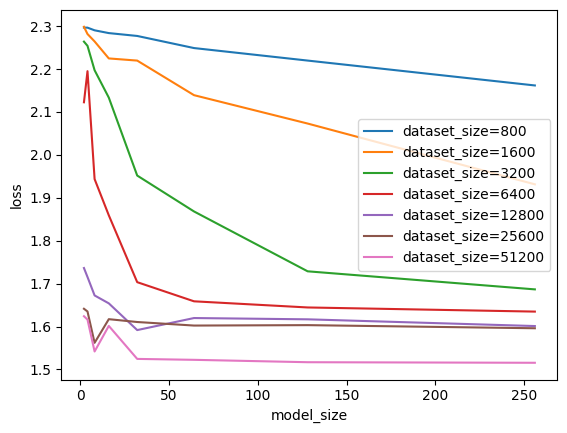

In [32]:
# plot results 
import matplotlib.pyplot as plt
import numpy as np

# load from json
with open('results.json') as json_file:
    results = json.load(json_file)

results = np.array([[result["model_size"], result["dataset_size"], result["loss"], result["memory_used"], result["percent"]] for result in results])
# results has elements with model_size, dataset_size, loss, memory_used
# we wanna plot the datasize vs loss for each model size
# one curve for each model size 

# plot model size vs loss
plt.figure()
for dataset_size in dataset_sizes:
    dataset_results = results[results[:,1] == dataset_size]
    plt.plot(dataset_results[:,0], dataset_results[:,2], label="dataset_size="+str(dataset_size))
plt.legend()
plt.xlabel("model_size")
plt.ylabel("loss")
if (dropout):
    plt.savefig("loss_vs_model_size_dropout.png")
else:
    plt.savefig("loss_vs_dataset_size.png")


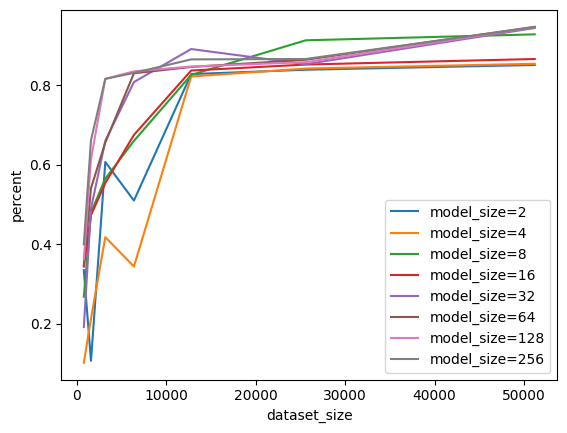

In [33]:
# now percent accuracy vs dataset size 

plt.figure()
for model_size in model_sizes:
    model_results = results[results[:,0] == model_size]
    plt.plot(model_results[:,1], model_results[:,4], label="model_size="+str(model_size))
plt.legend()
plt.xlabel("dataset_size")
plt.ylabel("percent")
if (dropout):
    plt.savefig("percent_vs_dataset_size_dropout.png")
else:
    plt.savefig("percent_vs_dataset_size.png")

In [34]:
# show me and classify some a test image for fun
image = images[51000]
label = labels[51000]
print(image)


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,